In [1]:
import numpy as np
import mne
import matplotlib
import scipy

from TimeFreqAna import *
from Preprocessing import *

from scipy import linalg, signal
from scipy.stats import ttest_ind

#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
            
from mne.preprocessing import ICA
from mne.datasets import sample
from mne.preprocessing.ica import corrmap 
from mne.channels import find_ch_connectivity, make_1020_channel_selections
from mne.stats import spatio_temporal_cluster_test
from mne.evoked import plot_evoked_image
from mne.minimum_norm import make_inverse_operator, apply_inverse_epochs, compute_source_psd_epochs, source_band_induced_power, source_induced_power, compute_source_psd


from mne.time_frequency import csd_fourier, tfr_multitaper, tfr_morlet, psd_welch, csd_morlet, AverageTFR
from mne.datasets import somato
from mne.connectivity import spectral_connectivity, seed_target_indices
from mne.viz import iter_topography
from mne.beamformer import make_dics, apply_dics_csd

from time import time


#%matplotlib inline

In [52]:
### DROPPED EPOCHS
import numpy as np
import mne

signal = mne.read_epochs('/home/robertofelipe_sg/Documents/Preprocessed/P65_Post30_preprocessed_epo.fif')
np.where([len(log) != 0 for log in signal.drop_log])

Reading /home/robertofelipe_sg/Documents/Preprocessed/P65_Post30_preprocessed_epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    1496.00 ms
        0 CTF compensation matrices available
150 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


(array([], dtype=int64),)

(1, 82500)
a 41250


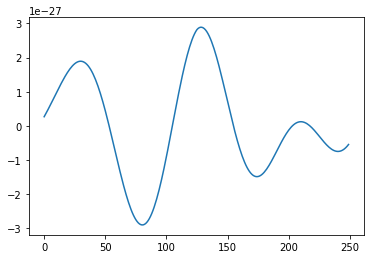

In [20]:
def cc(file, lo, hi):

    sf = 250 
    low = lo / sf/2
    high = hi /sf/2
    b, a = signal.butter(3, [low, high], btype='band') # Calculate coefficients
    filtered = signal.lfilter(b, a, file)# Filter signal

    nData = filtered.shape[0] * filtered.shape[2]
    #print(nData)
    conc1 = np.reshape(filtered[:,0,:], (1,nData))
    conc2 = np.reshape(filtered[:,1,:], (1,nData))
    corr = signal.correlate(conc1,conc2, mode='same', method='fft')
    print(corr.shape)

    a = int(len(corr.T)/2)
    print('a',a)
    
    return corr.T[a-125:a+125]

wave = np.load('/home/robertofelipe_sg/Documents/10.19/CrossFr_Sources/Data/Src/Src_V1V5_G1_Bsl_5.npy') #Epochs x V1V5 x Time-points
# print(len(wave))
corr_G1 = cc(wave, 7, 13)

plt.plot(corr_G1)

In [27]:
print((np.var(corr_G1))/(max(corr_G1)))
print(82500**2)
print(sum(corr_G1))

[7.94055867e-28]
6806250000
[2.79681004e-27]


Pandas computed Pearson r: 0.2058774513561943
Scipy computed Pearson r: 0.20587745135619345 and p-value: 3.790298947947356e-51


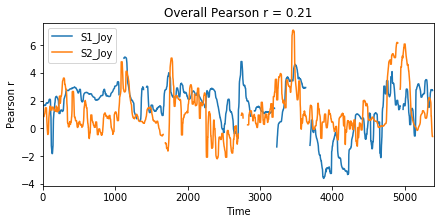

In [33]:

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

df = pd.read_csv('synchrony_sample.csv')
overall_pearson_r = df.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")
# out: Pandas computed Pearson r: 0.2058774513561943

r, p = stats.pearsonr(df.dropna()['S1_Joy'], df.dropna()['S2_Joy'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")
# out: Scipy computed Pearson r: 0.20587745135619354 and p-value: 3.7902989479463397e-51

# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(7,3))
df.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

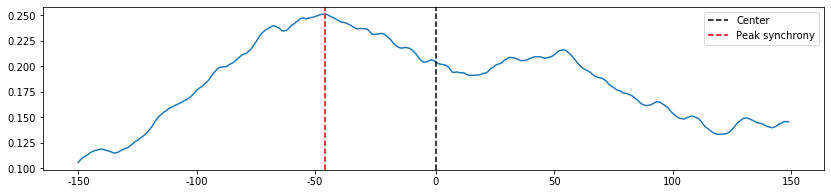

In [12]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = df['S1_Joy']
d2 = df['S2_Joy']
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
#offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
#ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[.1,.31],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend()

Reading P21_ICA+all_preprocessed_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    4096.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
63 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Applying baseline correction (mode: zscore)


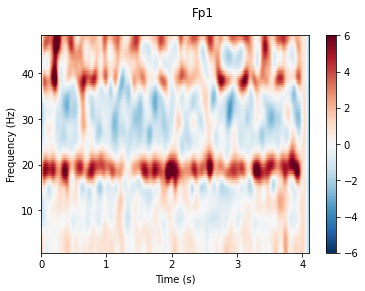

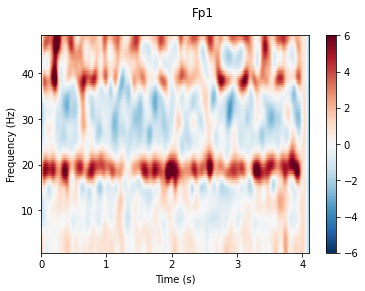

In [5]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet
# %matplotlib qt
%matplotlib inline

# epochs_resampled = mne.read_epochs('/home/robertofelipe_sg/Desktop/P01_RS_EO_EP0_post-resample_pre-ICA_-epo.fif')

# # ICA 
# ica = ICA(method='fastica', random_state=0)
# ica.fit(epochs_resampled)
# ica.plot_sources(epochs_resampled, block=True)
# print(ica.exclude)
# preprocessed = ica.apply(epochs_resampled)

preprocessed = mne.read_epochs('P21_ICA+all_preprocessed_epo.fif')

# TF
mode = 'zscore'
freqs = np.linspace(start=1, stop=48, num=96)
cycles = 3
n_cycles = freqs / cycles
base_1, base_2 = preprocessed.tmax-0.10, preprocessed.tmax

#plot tf graph
power,itc = tfr_morlet(preprocessed, freqs=freqs, n_cycles=n_cycles, zero_mean=True)
power.plot(picks=None, baseline=(base_1, base_2), mode=mode, vmin=-6, vmax=6, cmap='RdBu_r')



In [ ]:
import numpy as np
import mne
import matplotlib

matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

from mne.preprocessing import ICA
from mne.datasets import sample

from time import time

raw_path = '../../../Desktop/P21_RS_EO.vhdr'

# Read input file
raw = mne.io.read_raw_brainvision(raw_path, preload=True)

# Read montage file
montage = mne.channels.read_custom_montage(fname='ActCap_Sion.bvef')#, unit='auto')
print(type(montage))
raw.set_montage(montage)

# Event triggers and conditions
#     events = mne.find_events(raw)
events, _ = mne.events_from_annotations(raw)  

# Set EEG average reference
reference = raw.set_eeg_reference(ref_channels='average', projection=False) 

# Filtering
raw.notch_filter(freqs=(50,100), method='spectrum_fit', filter_length='5s')
raw.filter (l_freq=0.5, h_freq=105.0)
raw.filter (1., None, n_jobs=1, fir_design='firwin')

# Intermediate step
raw.plot_psd(tmax=np.inf, fmax=45)
picks = mne.pick_types(raw.info, meg=False, eeg=True)
print(picks)

# Epochs definition
baseline = (4, 4.1)  # means from the first instant to t = 0
tmin = 0
tmax = 4.1
event_id = 8
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False, picks=picks, detrend=1,
                    baseline=baseline, preload=True) # Based on signals from Trigger
print(epochs)
print(epochs.event_id)

# Plot & inspect epochs
scalings = dict(mag=1e-12, grad=4e-11, eeg=100e-6, eog=150e-6, ecg=5e-4,
     emg=1e-3, ref_meg=1e-12, misc=1e-3, stim=1, resp=1, chpi=1e-4,
     whitened=10.)
color = {8:'red'}
epochs.plot(block=True, scalings=scalings , n_channels=64, n_epochs=1, event_colors=color, events=events)

# Interpolate bad epochs
mne.Epochs.interpolate_bads(epochs, reset_bads=False, mode='accurate', verbose=False)
print(epochs.info['bads'])

# Resampling
epochs_resampled = epochs.copy().resample(250, npad='auto')
print('New sampling rate:', epochs_resampled.info['sfreq'], 'Hz')

# ICA 
ica = ICA(method='fastica', random_state=0)
ica.fit(epochs_resampled)
ica.plot_properties(epochs_resampled)
ica.plot_sources(epochs_resampled, block=True)
print(ica.exclude)

preprocessed = ica.apply(epochs_resampled)

#Save output
preprocessed.save('P21_ICA+all_preprocessed_epo.fif')


Extracting parameters from ../../../Desktop/P21_RS_EO.vhdr...
Setting channel info structure...
Reading 0 ... 314759  =      0.000 ...   314.759 secs...
<class 'mne.channels.montage.DigMontage'>
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


<ipython-input-1-d7ba6dc5c415>:21: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Removed notch frequencies (Hz):
     50.00 : 7812 windows
    100.00 : 7812 windows
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.0e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 105.00 Hz
- Upper transition bandwidth: 26.25 Hz (-6 dB cutoff frequency: 118.12 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower

<ipython-input-1-d7ba6dc5c415>:55: RuntimeWarning: Color was not assigned for event 99999. Default colors will be used.
  epochs.plot(block=True, scalings=scalings , n_channels=64, n_epochs=1, event_colors=color, events=events)


Dropped 0 epochs: 
Channels marked as bad: []
[]


<ipython-input-1-d7ba6dc5c415>:58: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  mne.Epochs.interpolate_bads(epochs, reset_bads=False, mode='accurate', verbose=False)


New sampling rate: 250.0 Hz
Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 62 components
Fitting ICA took 15.7s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
64 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [14]:
preprocessed.save('P21_510152025_preprocessed_epo.fif')


In [ ]:
Dropped 20 epochs: 2, 3, 6, 8, 10, 11, 13, 14, 19, 22, 27, 31, 32, 34, 42, 48, 52, 54, 58, 63
# Harmonics
# Filtering
# Eyes Open vs Closed
# ICA components
# Reminiscent Bursts artifact